<a href="https://colab.research.google.com/github/MariaSparrow/HSE_CS/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи

**Задача состоит в предсказании расходов за отказ от покупки конкретного товара (колонка item_losses).**

Данные сохранены
- [train](https://drive.google.com/file/d/1UkDps4djPbBHEiCCyDgQFvV3k2O9fMx2/view?usp=sharing)
- [test](https://drive.google.com/file/d/1lsc4zAWtNzPsFNIAofs5r0M_sy9UN_gk/view?usp=sharing)


 **Описание данных:**
    
    order_id - id заказа
    
    departure_country - id страны отправления заказа
    
    departure_city - id города отправления заказа
    
    departure_region - id региона города отправления заказа
    
    arrival_country - id страны получения заказа
    
    arrival_city - id города получения заказа
    
    arrival_region - id региона города получения заказа
    
    order_date - дата заказа
    
    stock_departure_date - время отправки со склада
    
    delivery_service_departure_date - время отправки службой доставки
    
    client_arrival_date - время доставки заказа в пункт получения
    
    item_type - тип товара (для кого предназначен)
    
    client_keywords - запрос для перехода клиента
    
    client_device_type - устройство клиента
    
    client_browser - браузер клиента
    
    item_package_type - способ упаковки
    
    client_is_app - заказ из приложения
    
    order_tracking_available - отслеживание заказа
    
    brand_name - название бренда
    
    item_id - id товара
    
    item_category - категория товара
    
    delivery_service_name - название службы доставки
    
    type_prepayment - тип предоплаты
    
    item_price - цена товара
    
    item_losses - расходы за отказ от покупки (целевая переменная)

 **План решения:**
 - первичный анализ данных
 - создание новых переменных
 - анализ целевого признака
 - построение моделей
 - выбор наилучшей модели
 - пргноз для тестовой выборки

# Загрузка и настройка библиотек

In [ ]:
!pip install catboost -q

In [ ]:
!pip install shap -q

In [ ]:
import pandas as pd
import numpy as np

from pandas import Timestamp

import catboost
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, mean_squared_error,
                             r2_score, mean_squared_log_error,
                             mean_absolute_error, roc_auc_score,
                             recall_score, precision_score, f1_score)


import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)

## загрузим данные

In [ ]:
!gdown 1UkDps4djPbBHEiCCyDgQFvV3k2O9fMx2
!gdown 1lsc4zAWtNzPsFNIAofs5r0M_sy9UN_gk

Downloading...
From: https://drive.google.com/uc?id=1UkDps4djPbBHEiCCyDgQFvV3k2O9fMx2
To: /content/df_train.csv
100% 102M/102M [00:00<00:00, 153MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1lsc4zAWtNzPsFNIAofs5r0M_sy9UN_gk
To: /content/df_test.csv
100% 28.1M/28.1M [00:00<00:00, 67.8MB/s]


In [ ]:
try:
  df_train = pd.read_csv('/content/df_train.csv').drop(columns='Unnamed: 0')
  df_test = pd.read_csv('/content/df_test.csv').drop(columns='Unnamed: 0')
except:
  df_train = pd.read_csv('df_train.csv').drop(columns='Unnamed: 0')
  df_test = pd.read_csv('df_test.csv').drop(columns='Unnamed: 0')


In [ ]:
df_test.head(2)

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price
0,3c39f09f-1f30-4d48-afd8-7ac959d4f2f3,12,125.0,824,12,121.0,1732,2018-05-15 14:41:20,19-35-00 2018-07-05,19-35-00 2018-07-05,23-33-00 2018-07-05,0,None,2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],340bd249-e659-4257-a2a3-c1eb8271183e,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,630.388722
1,660eec62-8547-4e5c-9981-afd14f2466f4,12,642.0,635,12,193.0,215,2018-05-08 14:22:07,03-32-00 2018-07-26,05-19-00 2018-07-28,03-01-00 2018-07-30,0,None,1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],85272285-4549-45be-a4f9-9e74687a21f5,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,1,1436.847481


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77837 entries, 0 to 77836
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   order_id                         77837 non-null  object 
 1   departure_country                77837 non-null  int64  
 2   departure_city                   76090 non-null  float64
 3   departure_region                 77837 non-null  int64  
 4   arrival_country                  77837 non-null  int64  
 5   arrival_city                     75418 non-null  float64
 6   arrival_region                   77837 non-null  int64  
 7   order_date                       77837 non-null  object 
 8   stock_departure_date             77837 non-null  object 
 9   delivery_service_departure_date  77837 non-null  object 
 10  client_arrival_date              77837 non-null  object 
 11  item_type                        77837 non-null  int64  
 12  client_keywords   

In [ ]:
df_train.head(2)

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,item_losses
0,1c25f312-fefc-41ee-b328-8fe1fd188e75,12,565.0,466,12,162.0,888,2017-12-27 09:49:55,00-48-00 2018-01-02,12-04-00 2018-01-03,18-09-00 2018-01-03,0,"[326, 51, 37]",1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],b1905241-ab8b-40e6-ae0a-8f614656f304,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,1,443.228241,0.0
1,c2a596a4-1a51-4269-b9f0-5c943c4f830d,12,361.0,292,12,121.0,351,2016-10-17 21:17:17,14-50-00 2016-11-02,21-33-00 2016-11-02,08-10-00 2016-11-03,0,[77],2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['9e20fbd2-b0aa-4b6a-ae04-0fb3724f5a5d', '73d1...",5121ddf1-2a2b-4cff-a1db-7b8550799cd6,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,589.481978,0.0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276205 entries, 0 to 276204
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   order_id                         276205 non-null  object 
 1   departure_country                276205 non-null  int64  
 2   departure_city                   269885 non-null  float64
 3   departure_region                 276205 non-null  int64  
 4   arrival_country                  276205 non-null  int64  
 5   arrival_city                     267342 non-null  float64
 6   arrival_region                   276205 non-null  int64  
 7   order_date                       276205 non-null  object 
 8   stock_departure_date             276205 non-null  object 
 9   delivery_service_departure_date  276205 non-null  object 
 10  client_arrival_date              276205 non-null  object 
 11  item_type                        276205 non-null  int64  
 12  cl

# EDA и преобразование данных


## приведем столбцы , где хранится дата и время к типу datetime



В данных не сказано в каком формате время с датами, предположим, что в формате UTC

In [ ]:
def convert_to_datetime(df: pd.DataFrame, datetime_cols: list, time_date_cols: list) -> pd.DataFrame:
    '''
    Function to convert columns to datetime format.

    Parameters:
        df (pd.DataFrame): Main DataFrame.
        datetime_cols (list): List of column names with values formatted as datetime (e.g., '2017-12-27 09:49:55').
        time_date_cols (list): List of column names with values formatted as time date (e.g., '09:49:55 2017-12-27').

    Returns:
        pd.DataFrame: DataFrame with specified columns converted to datetime format.
    '''

    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='raise')  # If 'raise', then invalid parsing will raise an exception.

    for col in time_date_cols:
        df[col] = pd.to_datetime(df[col], format='%H-%M-%S %Y-%m-%d', errors='raise')

    return df


In [ ]:
# список столбцов, в которых содержатся даты
cols_date_time = ['order_date',]
cols_time_date = ['stock_departure_date', 'delivery_service_departure_date', 'client_arrival_date',]

In [ ]:
df_train = convert_to_datetime(df_train, cols_date_time, cols_time_date)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276205 entries, 0 to 276204
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   order_id                         276205 non-null  object        
 1   departure_country                276205 non-null  int64         
 2   departure_city                   269885 non-null  float64       
 3   departure_region                 276205 non-null  int64         
 4   arrival_country                  276205 non-null  int64         
 5   arrival_city                     267342 non-null  float64       
 6   arrival_region                   276205 non-null  int64         
 7   order_date                       276205 non-null  datetime64[ns]
 8   stock_departure_date             276205 non-null  datetime64[ns]
 9   delivery_service_departure_date  276205 non-null  datetime64[ns]
 10  client_arrival_date              276205 non-

In [ ]:
df_test = convert_to_datetime(df_test, cols_date_time, cols_time_date)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77837 entries, 0 to 77836
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   order_id                         77837 non-null  object        
 1   departure_country                77837 non-null  int64         
 2   departure_city                   76090 non-null  float64       
 3   departure_region                 77837 non-null  int64         
 4   arrival_country                  77837 non-null  int64         
 5   arrival_city                     75418 non-null  float64       
 6   arrival_region                   77837 non-null  int64         
 7   order_date                       77837 non-null  datetime64[ns]
 8   stock_departure_date             77837 non-null  datetime64[ns]
 9   delivery_service_departure_date  77837 non-null  datetime64[ns]
 10  client_arrival_date              77837 non-null  datetime6

## анализ дубликатов

### проверка на полные дубликаты

In [ ]:

df_train.duplicated().sum()


565

In [ ]:
df_train.drop_duplicates(inplace=True)

In [ ]:
df_train.duplicated().sum()

0

### проверим, что order_id уникальный

In [ ]:
df_train['order_id'].shape[0], df_train['order_id'].nunique()

(275640, 193284)

In [ ]:
# посмотрим на пример таких дубликатов
(df_train.assign(order_id_2=df_train['order_id'])
            .groupby('order_id_2', as_index=False)
            .agg({'order_id': 'count'})
            .sort_values('order_id'))

,order_id_2,order_id
0,00006e62-59fa-449c-9ce3-d6325df6829f,1
117924,9c2be06d-2792-426a-8303-75e2e0dd7044,1
117925,9c2c1488-f71e-4abd-a585-994abb1dae18,1
117926,9c2c6953-7e96-433a-bcf6-d6498b2c7346,1
117927,9c2caf5a-7dba-427e-9456-2da8ac1db940,1
...,...,...
101665,8652b1fa-d9bd-47ee-9a36-f8986a59c223,16
7637,0a0dada6-fc0e-484d-a386-8eb12f64daf7,16
190540,fc40a438-023c-4bf5-9eb6-e6db602510be,17
133920,b162ce53-0aa6-40c3-932e-d2724b135cd8,18


In [ ]:
df_train[df_train['order_id'] == '4cd537ca-17da-4a07-bbc5-c0af6d56a47e']

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,item_losses
5388,4cd537ca-17da-4a07-bbc5-c0af6d56a47e,12,451.0,280,12,363.0,269,2017-06-05 20:48:55,2017-07-09 17:34:00,2017-07-09 19:23:00,2017-07-10 17:42:00,0,"[1, 41, 42, 3]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],09b5ad85-d5b5-4de3-8ca1-d300a7545117,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,2,866.388818,98.520531
17744,4cd537ca-17da-4a07-bbc5-c0af6d56a47e,12,451.0,280,12,363.0,269,2017-06-05 20:48:55,2017-07-09 17:34:00,2017-07-09 19:23:00,2017-07-10 17:42:00,0,"[1, 41, 42, 3]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],09b5ad85-d5b5-4de3-8ca1-d300a7545117,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,2,861.698987,98.520531
57740,4cd537ca-17da-4a07-bbc5-c0af6d56a47e,12,451.0,280,12,363.0,269,2017-06-05 20:48:55,2017-07-09 17:34:00,2017-07-09 19:23:00,2017-07-10 17:42:00,0,"[1, 41, 42, 3]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],09b5ad85-d5b5-4de3-8ca1-d300a7545117,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,2,862.722130,98.520531
65805,4cd537ca-17da-4a07-bbc5-c0af6d56a47e,12,451.0,280,12,363.0,269,2017-06-05 20:48:55,2017-07-09 17:34:00,2017-07-09 19:23:00,2017-07-10 17:42:00,0,"[1, 41, 42, 3]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],09b5ad85-d5b5-4de3-8ca1-d300a7545117,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,2,865.149716,98.520531
70405,4cd537ca-17da-4a07-bbc5-c0af6d56a47e,12,451.0,280,12,363.0,269,2017-06-05 20:48:55,2017-07-09 17:34:00,2017-07-09 19:23:00,2017-07-10 17:42:00,0,"[1, 41, 42, 3]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],09b5ad85-d5b5-4de3-8ca1-d300a7545117,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,2,859.752086,98.520531
75435,4cd537ca-17da-4a07-bbc5-c0af6d56a47e,12,451.0,280,12,363.0,269,2017-06-05 20:48:55,2017-07-09 17:34:00,2017-07-09 19:23:00,2017-07-10 17:42:00,0,"[1, 41, 42, 3]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],09b5ad85-d5b5-4de3-8ca1-d300a7545117,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,2,860.389879,98.520531
77811,4cd537ca-17da-4a07-bbc5-c0af6d56a47e,12,451.0,280,12,363.0,269,2017-06-05 20:48:55,2017-07-09 17:34:00,2017-07-09 19:23:00,2017-07-10 17:42:00,0,"[1, 41, 42, 3]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],09b5ad85-d5b5-4de3-8ca1-d300a7545117,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,2,864.397542,98.520531
94986,4cd537ca-17da-4a07-bbc5-c0af6d56a47e,12,451.0,280,12,363.0,269,2017-06-05 20:48:55,2017-07-09 17:34:00,2017-07-09 19:23:00,2017-07-10 17:42:00,0,"[1, 41, 42, 3]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],09b5ad85-d5b5-4de3-8ca1-d300a7545117,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,2,858.611319,98.520531
95420,4cd537ca-17da-4a07-bbc5-c0af6d56a47e,12,451.0,280,12,363.0,269,2017-06-05 20:48:55,2017-07-09 17:34:00,2017-07-09 19:23:00,2017-07-10 17:42:00,0,"[1, 41, 42, 3]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],09b5ad85-d5b5-4de3-8ca1-d300a7545117,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,2,862.136294,98.520531
97282,4cd537ca-17da-4a07-bbc5-c0af6d56a47e,12,451.0,280,12,363.0,269,2017-06-05 20:48:55,2017-07-09 17:34:00,2017-07-09 19:23:00,2017-07-10 17:42:00,0,"[1, 41, 42, 3]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],09b5ad85-d5b5-4de3-8ca1-d300a7545117,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,2,857.241410,98.520531


>Внутри одного order_id может быть несколько строк, в рамках одного заказа было заказано несколько товаров

может ли внутри order_id какие-либо товары прийти в разное время?

In [ ]:
df_train_agg = df_train.groupby('order_id', as_index=False).agg({'order_date':['min', 'max'],
                                                'stock_departure_date':['min', 'max'],
                                                'delivery_service_departure_date':['min', 'max'],
                                                'client_arrival_date':['min', 'max']	})
df_train_agg.columns = ['order_id',
                        'order_date_min', 'order_date_max',
                        'delivery_service_departure_date_min', 'delivery_service_departure_date_max',
                        'stock_departure_min', 'stock_departure_max',
                        'client_arrival_date_min', 'client_arrival_date_max'
                        ]

In [ ]:
cond1 = (df_train_agg['order_date_min'] != df_train_agg['order_date_max'])
cond2 = (df_train_agg['client_arrival_date_min'] != df_train_agg['client_arrival_date_max'])
cond3 = (df_train_agg['delivery_service_departure_date_min'] != df_train_agg['delivery_service_departure_date_max'])
cond4 = (df_train_agg['stock_departure_min'] != df_train_agg['stock_departure_max'])

df_train_agg[cond1 | cond2 | cond3 | cond4]

,order_id,order_date_min,order_date_max,delivery_service_departure_date_min,delivery_service_departure_date_max,stock_departure_min,stock_departure_max,client_arrival_date_min,client_arrival_date_max


>внутри одного заказа товары проходит все стадии одновременно

Проверим, возможно ли такое, что внутри одного заказа от части товаров отказались и  были расходы за отказ от покупки

In [ ]:
df_train_agg = df_train.groupby('order_id', as_index=False).agg({'item_losses':['min', 'max',]})
df_train_agg.columns = ['order_id', 'item_losses_min', 'item_losses_max',]
df_train_agg[df_train_agg['item_losses_min'] != df_train_agg['item_losses_max']]

,order_id,item_losses_min,item_losses_max
19,00055aa4-b6f5-4c41-8d27-8dee621d60b9,0.000000,65.470494
57,0010b0fe-16d5-4932-bb3d-1f9b0511a07e,0.000000,32.838976
58,0010db92-1828-4e8f-976a-f3d1ceb60599,74.086922,94.772041
73,001679e6-7c80-4bd4-a478-de15e5b80602,0.000000,77.179692
133,0029020a-1d98-4740-88b2-be7587caf8d1,111.921793,133.110793
...,...,...,...
193203,ffdf85c2-1a71-49da-ab83-71cabf99734b,0.000000,99.468599
193209,ffe16eda-10de-4293-9ac3-67f107c4b884,0.000000,50.270884
193227,ffe8289e-e990-43b0-8f48-f207678b85dc,49.259000,95.332126
193261,fff6adfc-df0e-4f73-bb35-6ae9c7c14134,90.479798,114.150060


>то есть от части товаров могут отказаться и компания понесет расходы за отказ покупки  
То есть внутри одного заказа потери от отказа покупкии могут быть разными, следовательно обучающую выборку для модели необходимо строить на уровне order_id, item_id

## анализ распределения признаков

### item_type тип товара (для кого предназначен)

In [ ]:
df_train['item_type'].value_counts(normalize=True)

0    0.921376
1    0.061250
2    0.017374
Name: item_type, dtype: float64

>есть тип товаров (для кого предназначен), у которых доля по всей выборке менее 1%

### client_device_type - устройство клиента

In [ ]:
df_train['client_device_type'].value_counts(normalize=True)

2       0.635906
1       0.155253
0       0.147696
3       0.052155
80      0.000272
          ...   
692     0.000004
165     0.000004
908     0.000004
1140    0.000004
70      0.000004
Name: client_device_type, Length: 468, dtype: float64

>типов устройства клиента 458 различных значений, наиболее частый тип - 2


### client_browser - браузер клиента

In [ ]:
df_train['client_browser'].value_counts(normalize=True)

1    0.414305
0    0.332989
6    0.088655
3    0.057593
2    0.049227
4    0.031255
5    0.025972
9    0.000004
Name: client_browser, dtype: float64

>типов браузера 8  различных значений, наиболее частый тип - 1


### item_package_type - способ упаковки

In [ ]:
df_train['item_package_type'].value_counts(normalize=True)

c82a2ea6-cbf1-46af-98c5-acd43b174f5d    0.797116
4b30b1ff-54b0-4aac-ac8a-6df7bb59548e    0.091061
43c32a76-e5a3-4874-85c3-5377fa50b515    0.062872
7b0818f4-617e-4843-a5c1-634d2c2a3c2f    0.046800
1d030b8e-b455-4e27-9d19-c68c1d7924a4    0.002151
Name: item_package_type, dtype: float64

>типов упаковки 5 штук, есть наиболее частый , который встречается более 79%

### client_is_app - заказ из приложения

In [ ]:
df_train['client_is_app'].value_counts(normalize=True)

True     0.964185
False    0.035815
Name: client_is_app, dtype: float64

>чаще всего клиенты заказывает из приложения

### order_tracking_available - отслеживание заказа

In [ ]:
df_train['order_tracking_available'].value_counts(normalize=True)

0    0.963674
1    0.036326
Name: order_tracking_available, dtype: float64

> чаще всего возможность отслеживания заказа есть

### brand_name - название бренда

In [ ]:
df_train['brand_name'].value_counts(normalize=True)

[]                                                                                  0.544402
['f4e0584f-4dd0-494a-a2e1-8e1f0197df31']                                            0.118695
['e5154844-2e6c-48ba-883b-2564eb8b8261']                                            0.057513
['dade2508-0a6f-47f6-a2a3-f15a7e60969e']                                            0.026219
['e8ace2ea-968a-408c-a992-bb5924c01239']                                            0.023948
                                                                                      ...   
['13c54d7c-f0ed-4319-8d1b-7fa572eeda31']                                            0.000011
['caf89326-3ec5-4a8d-b179-8c47d4f969e2']                                            0.000007
['15fa33ce-c07b-483d-b0be-5c9f99caaecb', '7eeb0c98-862e-4504-bf94-d03fb2bd8467']    0.000007
['b0c30def-4db0-4086-9544-d35f76a0b299']                                            0.000004
['c5677df9-354a-47c6-98cf-7394b8522c03']                              

>в поле может быть сразу несколько брендов, чаще всего 54.4% бренд просто не заполнен.

Посмотрим, количество брендов зависит от количества item_id в заказе

In [ ]:
# создадим переменную количество брендов
df_train['count_brand_name'] = df_train['brand_name'].map(lambda x:
                                                          len(x.replace("[", "").replace("]", "").split(sep=","))
                                                          if x != "[]"
                                                          else 0
                                                          )

In [ ]:
# и для теста
df_test['count_brand_name'] = df_test['brand_name'].map(lambda x:
                                                          len(x.replace("[", "").replace("]", "").split(sep=","))
                                                          if x != "[]"
                                                          else 0
                                                          )

In [ ]:
# df_train[['count_brand_name', 'brand_name']]
# df_train[df_train['count_brand_name']>1]
df_train[df_train['order_id'] == 'c2a596a4-1a51-4269-b9f0-5c943c4f830d']

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,item_losses,count_brand_name
1,c2a596a4-1a51-4269-b9f0-5c943c4f830d,12,361.0,292,12,121.0,351,2016-10-17 21:17:17,2016-11-02 14:50:00,2016-11-02 21:33:00,2016-11-03 08:10:00,0,[77],2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['9e20fbd2-b0aa-4b6a-ae04-0fb3724f5a5d', '73d1...",5121ddf1-2a2b-4cff-a1db-7b8550799cd6,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,589.481978,0.0,2
121138,c2a596a4-1a51-4269-b9f0-5c943c4f830d,12,361.0,292,12,121.0,351,2016-10-17 21:17:17,2016-11-02 14:50:00,2016-11-02 21:33:00,2016-11-03 08:10:00,0,[77],2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['9e20fbd2-b0aa-4b6a-ae04-0fb3724f5a5d', '73d1...",5121ddf1-2a2b-4cff-a1db-7b8550799cd6,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,811.837836,0.0,2


In [ ]:
print(df_train.shape)
df_train = df_train.merge(df_train.groupby('order_id',
                                           as_index=False).agg({'item_id':'count'}).rename(
                                              columns={'item_id':'count_items'}),
                          on = 'order_id')
print(df_train.shape)

(275640, 26)
(275640, 27)


In [ ]:
print(df_test.shape)
df_test = df_test.merge(df_test.groupby('order_id',
                                           as_index=False).agg({'item_id':'count'}).rename(
                                              columns={'item_id':'count_items'}),
                          on = 'order_id')
print(df_test.shape)

(77837, 25)
(77837, 26)


In [ ]:
# бывают ли такие ситуации, когда количество брендов больше, чем количество товаров в заказе
df_train[df_train['count_brand_name'] > df_train['count_items']].shape[0], \
df_train[df_train['count_brand_name'] > df_train['count_items']].shape[0]/df_train.shape[0]

(14999, 0.05441517921927151)

In [ ]:
df_train[df_train['count_brand_name'] > df_train['count_items']][['count_brand_name','count_items']].drop_duplicates()




,count_brand_name,count_items
8,2,1
1514,6,2
3206,4,3
4208,5,1
4249,4,2
4355,4,1
9226,5,2
14963,6,3
24142,6,1
25519,5,3


In [ ]:
df_train[df_train['order_id'] == 'd84abb0b-29f3-47bd-886e-c7cd3866bc7a']['brand_name'].values

array(["['3816a29d-7d91-472b-a8b9-7367327800ed', 'af1b983a-2992-4d33-b301-055a9f05dfca']"],
      dtype=object)

In [ ]:
df_train[df_train['order_id'] == 'd84abb0b-29f3-47bd-886e-c7cd3866bc7a']

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,item_losses,count_brand_name,count_items
8,d84abb0b-29f3-47bd-886e-c7cd3866bc7a,12,125.0,1666,12,634.0,530,2017-04-26 18:23:43,2017-05-06 21:15:00,2017-05-06 21:15:00,2017-05-07 00:37:00,0,None,3,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['3816a29d-7d91-472b-a8b9-7367327800ed', 'af1b...",3bba1740-10f2-47e9-81c4-a75ec9b4445a,5554bea4-f3cd-4432-bb13-73698f52de88,5c8a6701-853f-4721-86f0-86e79f7220c4,2,110.94696,0.0,2,1


>странная ситуация: количество товаров меньше количества брендов. Таких ситуаций около 5.4%
Нужна срочно встреча с бизнес-экспертами :-) Надеюсь, они смогут объяснить, такое возможно или это косяк в данных?

Так как я не могу объяснить что это такое, оставим данные без изменения

### item_category - категория товара

In [ ]:
df_train['item_category'].value_counts(normalize=True)

ea77a36e-4b0c-4e8d-bf09-4c8398609ae1    0.358961
25f9f297-40a8-45d9-bb67-4b0f6dad1315    0.291104
5554bea4-f3cd-4432-bb13-73698f52de88    0.287625
60959c0c-9c1a-434b-8442-3b8c2fc73655    0.052423
243f0bd2-7e7b-4b32-96f9-5bd080948936    0.005935
38541b4d-f0d3-4471-abbc-574f4f1779c8    0.003951
Name: item_category, dtype: float64

>всего 6 категорий товара в обучающей выборке, 3 из которых заказывают редко, менее 1%

### delivery_service_name - название службы доставки

In [ ]:
print(f"количество разных служб доставки {df_train['delivery_service_name'].nunique()}\n")
df_train['delivery_service_name'].value_counts(normalize=True)

количество разных служб доставки 25



5c8a6701-853f-4721-86f0-86e79f7220c4    0.752191
eec00286-b56b-44b0-8882-7b7022355a8f    0.121720
409f1e13-81ae-4e36-9bd2-6a6c53d38601    0.042385
3f1e3d6a-a194-4cf9-9026-bb03a8f544c2    0.021873
85282487-c17a-41ff-bedd-d0461a3e7330    0.020723
fcaa3980-7779-4590-9c18-8ce1c03b6ee9    0.018321
bcf8f840-043b-4637-a283-16e561d6a86c    0.007114
56ecf0d7-73dd-4fee-80c3-9165a889088d    0.004063
202230b2-235b-4dda-ad57-3a722d4cce5b    0.003519
42f718fe-d3b9-40e6-b5c7-e1cb31e7a7b5    0.003095
12fbc04a-c648-492c-9493-e21a792f228e    0.001720
b56d0da5-84b6-457a-9594-fdd0cd2cae13    0.000965
99e0a8dc-c1f1-4b62-bbd8-e429dbb18c31    0.000758
8742ac10-bec1-4d59-8514-604173977b8d    0.000646
831e66de-a6e9-4cff-b411-8c644b15e8a0    0.000370
a3fbdc94-4e7f-4d9e-bce6-33836a18e294    0.000229
6aa940a0-5d1a-4b33-8346-6a5c8c9d8af4    0.000189
bf42578f-62fd-4022-bb3d-ade42eb27b1e    0.000033
1b24a233-92c5-486a-acce-a337ff14fa21    0.000022
5b3f20f0-d81d-4abe-add6-cbc79ab88cab    0.000018
2df23a19-e607-4a38-a

>всего 35 различных служб доставки, есть 1 частоиспользуемая

### type_prepayment - тип предоплаты

In [ ]:
df_train['type_prepayment'].value_counts(normalize=True)

2    0.835100
1    0.090303
0    0.074510
3    0.000087
Name: type_prepayment, dtype: float64

>4 вида предоплаты, 2 тип наиболее распространен

### item_price - цена товара

<Axes: >

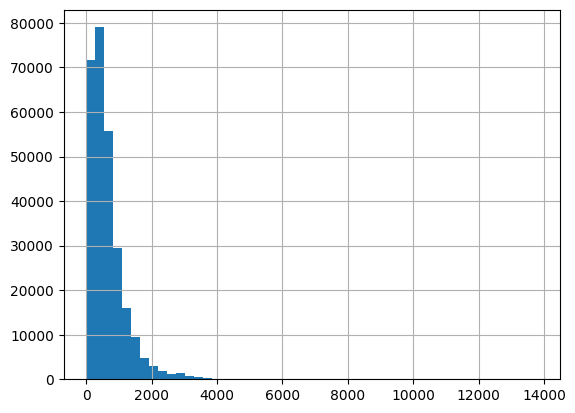

In [ ]:
df_train['item_price'].hist(bins=50)

In [ ]:
df_train['item_price'].describe()

count    275640.000000
mean        636.887267
std         564.851315
min           0.000000
25%         263.346720
50%         490.651507
75%         828.791177
max       13787.240979
Name: item_price, dtype: float64

>в данных есть товары с 0 стоимостью, скорее всего это товары, которые идут как подарки, либо оплачиваются бонусами (на практике я бы уточнила этот вопрос у бизнес-экспертов)

In [ ]:
df_train

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,item_losses,count_brand_name,count_items
0,1c25f312-fefc-41ee-b328-8fe1fd188e75,12,565.0,466,12,162.0,888,2017-12-27 09:49:55,2018-01-02 00:48:00,2018-01-03 12:04:00,2018-01-03 18:09:00,0,"[326, 51, 37]",1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],b1905241-ab8b-40e6-ae0a-8f614656f304,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,1,443.228241,0.000000,0,6
1,1c25f312-fefc-41ee-b328-8fe1fd188e75,12,565.0,466,12,162.0,888,2017-12-27 09:49:55,2018-01-02 00:48:00,2018-01-03 12:04:00,2018-01-03 18:09:00,1,"[326, 51, 37]",1,0,4b30b1ff-54b0-4aac-ac8a-6df7bb59548e,True,0,[],b1905241-ab8b-40e6-ae0a-8f614656f304,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,1,168.039328,0.000000,0,6
2,1c25f312-fefc-41ee-b328-8fe1fd188e75,12,565.0,466,12,162.0,888,2017-12-27 09:49:55,2018-01-02 00:48:00,2018-01-03 12:04:00,2018-01-03 18:09:00,1,"[326, 51, 37]",1,0,4b30b1ff-54b0-4aac-ac8a-6df7bb59548e,True,0,[],b1905241-ab8b-40e6-ae0a-8f614656f304,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,1,161.816330,0.000000,0,6
3,1c25f312-fefc-41ee-b328-8fe1fd188e75,12,565.0,466,12,162.0,888,2017-12-27 09:49:55,2018-01-02 00:48:00,2018-01-03 12:04:00,2018-01-03 18:09:00,0,"[326, 51, 37]",1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],b1905241-ab8b-40e6-ae0a-8f614656f304,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,1,440.367079,0.000000,0,6
4,1c25f312-fefc-41ee-b328-8fe1fd188e75,12,565.0,466,12,162.0,888,2017-12-27 09:49:55,2018-01-02 00:48:00,2018-01-03 12:04:00,2018-01-03 18:09:00,0,"[326, 51, 37]",1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],b1905241-ab8b-40e6-ae0a-8f614656f304,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,1,441.865839,0.000000,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275635,f1993ec0-8b9c-4294-84fd-8bd22a1b22a2,12,124.0,884,12,121.0,1405,2018-01-10 21:22:31,2018-01-12 21:35:00,2018-01-13 00:15:00,2018-01-13 07:31:00,1,None,0,0,4b30b1ff-54b0-4aac-ac8a-6df7bb59548e,True,0,['e1898b36-c7a1-4687-b392-9635468e4c09'],14305c15-fd45-4d20-9b36-39deabfc4bd2,60959c0c-9c1a-434b-8442-3b8c2fc73655,85282487-c17a-41ff-bedd-d0461a3e7330,0,485.921588,91.250665,1,1
275636,a7e2151c-fa90-4541-9ee0-4793ed3a15e9,12,257.0,1099,12,121.0,36,2017-07-21 02:20:41,2017-07-23 19:10:00,2017-07-23 21:36:00,2017-07-23 23:25:00,0,None,0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['e5154844-2e6c-48ba-883b-2564eb8b8261'],512418d9-a987-41af-9333-c67efb61d1ff,5554bea4-f3cd-4432-bb13-73698f52de88,5c8a6701-853f-4721-86f0-86e79f7220c4,2,157.928053,67.511360,1,1
275637,7b336012-b366-439c-b56a-7770f779a276,12,291.0,477,12,121.0,351,2018-02-26 17:50:30,2018-03-07 21:50:00,2018-03-07 21:50:00,2018-03-08 11:10:00,0,"[3, 4, 164]",2,3,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],699a5054-1543-4644-9efc-79d3ac240696,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,1,404.201279,0.000000,0,1
275638,7027351f-59f8-4651-80da-5273bd463fc6,12,121.0,1732,12,125.0,824,2017-04-28 00:36:35,2017-05-22 08:05:00,2017-05-22 08:05:00,2017-05-22 12:22:00,0,"[3, 4, 10]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],252f0bdb-8226-4f4e-b19d-3dcd4959487d,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,2,575.198125,0.000000,1,1


## анализ явных пропусков

In [ ]:
df_train.isna().sum().sort_values()

order_id                              0
item_losses                           0
item_price                            0
type_prepayment                       0
delivery_service_name                 0
item_category                         0
item_id                               0
brand_name                            0
order_tracking_available              0
client_is_app                         0
item_package_type                     0
client_browser                        0
count_brand_name                      0
client_device_type                    0
item_type                             0
client_arrival_date                   0
delivery_service_departure_date       0
stock_departure_date                  0
order_date                            0
arrival_region                        0
arrival_country                       0
departure_region                      0
departure_country                     0
client_keywords                       0
count_items                           0


In [ ]:
df_test.isna().sum().sort_values()

order_id                              0
item_price                            0
type_prepayment                       0
delivery_service_name                 0
item_category                         0
item_id                               0
brand_name                            0
order_tracking_available              0
client_is_app                         0
item_package_type                     0
client_browser                        0
client_device_type                    0
client_keywords                       0
item_type                             0
client_arrival_date                   0
delivery_service_departure_date       0
stock_departure_date                  0
order_date                            0
arrival_region                        0
arrival_country                       0
departure_region                      0
departure_country                     0
count_brand_name                      0
count_items                           0
departure_city                     1747


In [ ]:
# сколько % от всей тренировочной выборки удалим данных, если удалить строки с пропусками по arrival_city, departure_city
df_train[(pd.isnull(df_train['departure_city'])) | \
         (pd.isnull(df_train['arrival_city']))].shape[0]/df_train.shape[0]

0.05376940937454651

пропуски только у 2 столбцов: arrival_city, departure_city

по работе с пропусками возможно 2 стратегии:
- удалить строки с пропусками. Если удалить данные, то удалим всего 5.4% от всей тренировочной выборки

- либо заменить пропуски




In [ ]:
# сколько % от всей выборки удалим данных, если удалить строки с пропусками по arrival_city, departure_city
df_test[(pd.isnull(df_test['departure_city'])) | \
        (pd.isnull(df_test['arrival_city']))].shape[0]/df_train.shape[0]

0.014881729792482949

Так как в тестовой выборке также есть пропуски по городам, удалять данные нельзя, необходимо пропуски по городам восстановить

Заполним пропуски по arrival_city, departure_city

Для этого создадим дополнительный DataFrame, который будет содержать только город, регион и страну

In [ ]:
df_cities = pd.concat([df_train[['arrival_country',
                                 'arrival_region',
                                 'arrival_city']].rename(columns={'arrival_country':'country',
                                                          'arrival_region':'region',
                                                          'arrival_city':'city'}),
                       df_train[['departure_country',
                                 'departure_region',
                                 'departure_city']].rename(columns={'departure_country':'country',
                                                            'departure_region':'region',
                                                            'departure_city':'city'})
                       ])
df_cities.head()

,country,region,city
0,12,888,162.0
1,12,888,162.0
2,12,888,162.0
3,12,888,162.0
4,12,888,162.0


In [ ]:
# проверим, что после объединения ничего не сломалось и количество пропусков сохранилось
assert df_cities.isna().sum().city == df_train.isna().sum().departure_city + df_train.isna().sum().arrival_city

In [ ]:
# проверим, что после объединения ничего не сломалось и количество строк просто умножилось на 2
assert df_cities.shape[0] == df_train.shape[0]*2

In [ ]:
df_cities[~pd.isna(df_cities['city'])].groupby('region',
                                                as_index=False).agg({'city':'nunique'})['city'].unique()


array([1])

>внутри города 1 регион, Попробуем восстановить город на основании региона

In [ ]:
def check_null_values(df:pd.DataFrame, col_with_null:str, col_for_help:str ) -> pd.DataFrame:
  set_not_null = set(df[~pd.isnull(df[col_with_null])][col_for_help].unique())
  set_null = set(df[pd.isnull(df[col_with_null])][col_for_help].unique())
  return set_not_null.intersection(set_null)

In [ ]:
check_null_values(df_cities, 'city', 'region' )

set()

>пересечение пусто, следовательно восстановить город по региону не сможем (очень жаль, так бы мы восстановили город однозначно)

In [ ]:
df_cities[~pd.isna(df_cities['city'])].groupby('country',
                                                as_index=False).agg({'city':'nunique'})['city'].unique()


array([  1,  25,  16,   3,   4,   6,   2, 554,  64])

>страна может содержать несколько городов, что логично  
восстановить однозначно по стране город не получится

>В итоге, пропуски по городу  заполним искуственными ID:
 - на основании страны и региона: city = -1*(country + 1 + region). Преполагаем, что настоящие ID неотрицательные. При этом, в таком заполнении есть риск, что какие-то города мы разделим.



In [ ]:
def fill_null_values_for_city(df:pd.DataFrame,
                              col_city:str,
                              col_region:str,
                              col_country:str) -> pd.DataFrame:
  df[col_city] = df.apply(lambda x: -1*(x[col_country] + x[col_region] +1)
                                    if pd.isnull(x[col_city])
                                    else x[col_city],
                          axis=1)
  df[col_city] = df[col_city].astype(int)
  return df


In [ ]:
df_train = fill_null_values_for_city(df_train,
                                     'arrival_city',
                                     'arrival_region',
                                     'arrival_country')

In [ ]:
df_train = fill_null_values_for_city(df_train,
                                     'departure_city',
                                     'departure_region',
                                     'departure_country')

In [ ]:
df_test = fill_null_values_for_city(df_test,
                                     'arrival_city',
                                     'arrival_region',
                                     'arrival_country')
df_test = fill_null_values_for_city(df_test,
                                     'departure_city',
                                     'departure_region',
                                     'departure_country')

## анализ целевой переменной (item_losses - расходы за отказ от покупки )

<Axes: >

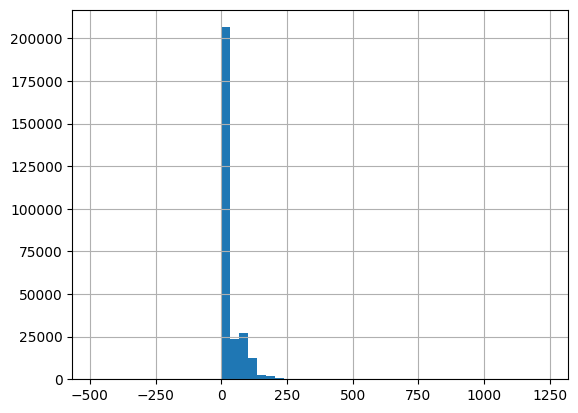

In [ ]:
df_train['item_losses'].hist(bins=50)

In [ ]:
df_train['item_losses'].describe()

count    275640.000000
mean         23.632594
std          47.800450
min        -480.848430
25%           0.000000
50%           0.000000
75%          34.306187
max        1234.954697
Name: item_losses, dtype: float64

In [ ]:
df_train[df_train['item_losses']<0]

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,item_losses,count_brand_name,count_items
86956,be4127b1-38e3-401d-8548-79f6b34c2cb2,12,125,824,12,276,1253,2017-06-28 02:45:39,2017-08-25 21:02:00,2017-08-25 21:02:00,2017-08-27 10:46:00,0,None,1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,False,0,"['fe714603-2276-40f8-b021-ca9d205c8e41', '1f56...",3da7a462-538e-42bf-b4b6-6709d6afce7f,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,2125.041051,-23.784722,2,3
86957,be4127b1-38e3-401d-8548-79f6b34c2cb2,12,125,824,12,276,1253,2017-06-28 02:45:39,2017-08-25 21:02:00,2017-08-25 21:02:00,2017-08-27 10:46:00,0,None,1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,False,0,"['fe714603-2276-40f8-b021-ca9d205c8e41', '1f56...",3da7a462-538e-42bf-b4b6-6709d6afce7f,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,2125.274981,-23.784722,2,3
97180,c290ce6a-acac-40cb-aaea-77ef3be79a67,12,556,1443,12,68,1274,2017-06-01 18:26:28,2017-07-24 21:10:00,2017-07-24 21:10:00,2017-07-25 23:06:00,0,None,2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],fe1c74ac-e22d-445f-a1cd-6ea30fc85957,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,963.377195,-310.123792,0,2
97181,c290ce6a-acac-40cb-aaea-77ef3be79a67,12,556,1443,12,68,1274,2017-06-01 18:26:28,2017-07-24 21:10:00,2017-07-24 21:10:00,2017-07-25 23:06:00,0,None,2,1,4b30b1ff-54b0-4aac-ac8a-6df7bb59548e,True,0,[],fe1c74ac-e22d-445f-a1cd-6ea30fc85957,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,698.287201,-480.848430,0,2


>целевой признак item_losses имеет в основном неотрицательные значения, только 4 значения отрицательны. Предположим, что это ошибки в данных, по этой причине удалим их из выборки

In [ ]:
df_train = df_train[df_train['item_losses']>=0].copy()

In [ ]:
df_train[df_train['item_losses'] == 0].shape[0]/df_train.shape[0]

0.7245642804278106

>Целевая переменная содержит 72.5% нулевых значений, распределение сильно скошенное

# Построение  выборки для модели


- Одна строка в обучающей выборке: order_id+item_id (выше выяснили, что item_losses для этой пары разный и следовательно прогноз item_losses необходимо строить на уровне order_id+item_id )
- создадим дополнительные признаки, описывающий сам заказ
 - количество товаров в заказе
 - суммарная стоимость заказа
 - есть ли в заказе товары с 0 стоимостью (возможно это промо или бонусы и они могут быть полезны)
 - количество категорий в заказе

- создадим дополнительные переменные по  order_id+item_id:
 - сколько до даты заказа заказывали товаров категории item_category. Важно, что подобные переменные должны быть посчитаны именно до даты заказа, чтобы не захватить инфо из будущего

- переменные на основании дат

Так как распределение целевой переменной сильно скошенное и имеет 72.5% нулевых значений, то логично попробовать применить двуступенчатый подход:
 - на 1 уровне строим классификацию (отказ/ не отказ)
 - на 2-ом уровне строим регрессию, если от товара отказались, какие расходы нас ожидают

По этой причине целевую переменную разобьём на 2 переменные:
 - бинарная (1- отказ/0- не отказ)
 - вещественная - item_losses (какие расходы нас ожидают)
 - финальный прогноз может быть расчитан 2 способами:
  - вероятность от бинарной модели * прогноз регрессии
  - если вероятность от бинарной модели меньше cutoff, то 0, иначе прогноз регрессии


 В рамках данного анализа построим 2 модели:  

 1) базовая модель - просто регрессия с таргетом item_losses

 2) двуступенчатая модель

## дополнительные признаки, описывающий сам заказ

In [ ]:
# количество товаров в заказе (count_items) - была создана на этапе анализа brand_name -
# суммарная стоимость заказа
# количество категорий в заказе
print(df_train.shape)
df_train = df_train.merge(df_train.groupby('order_id',
                                           as_index=False).agg({'item_price':'sum',
                                                                'item_category':'nunique'}).rename(
                                              columns={'item_price':'sum_item_price',
                                                       'item_category':'number_uniq_item_category'}),
                          on = 'order_id')
print(df_train.shape)


(275636, 27)
(275636, 29)


In [ ]:
print(df_test.shape)
df_test = df_test.merge(df_test.groupby('order_id',
                                           as_index=False).agg({'item_price':'sum',
                                                                'item_category':'nunique'}).rename(
                                              columns={'item_price':'sum_item_price',
                                                       'item_category':'number_uniq_item_category'}),
                          on = 'order_id')
print(df_test.shape)


(77837, 26)
(77837, 28)


In [ ]:
# есть ли в заказе товары с 0 стоимостью
#  (возможно это промо или бонусы и они могут быть полезны)
df_train['item_price_more_0'] = df_train['item_price'].map(lambda x:
                                                           1 if x == 0 else 0)
print(df_train.shape)
df_train = df_train.merge(df_train.groupby('order_id',
                                           as_index=False).agg({'item_price_more_0':'sum',
                                                                }).rename(
                                              columns={'item_price_more_0':'sum_item_with_price_0',
                                                       }),
                          on = 'order_id')
print(df_train.shape)

(275636, 30)
(275636, 31)


In [ ]:
df_test['item_price_more_0'] = df_test['item_price'].map(lambda x:
                                                           1 if x == 0 else 0)
print(df_test.shape)
df_test = df_test.merge(df_test.groupby('order_id',
                                           as_index=False).agg({'item_price_more_0':'sum',
                                                                }).rename(
                                              columns={'item_price_more_0':'sum_item_with_price_0',
                                                       }),
                          on = 'order_id')
print(df_test.shape)

(77837, 29)
(77837, 30)


In [ ]:
df_train.tail()

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,item_losses,count_brand_name,count_items,sum_item_price,number_uniq_item_category,item_price_more_0,sum_item_with_price_0
275631,f1993ec0-8b9c-4294-84fd-8bd22a1b22a2,12,124,884,12,121,1405,2018-01-10 21:22:31,2018-01-12 21:35:00,2018-01-13 00:15:00,2018-01-13 07:31:00,1,None,0,0,4b30b1ff-54b0-4aac-ac8a-6df7bb59548e,True,0,['e1898b36-c7a1-4687-b392-9635468e4c09'],14305c15-fd45-4d20-9b36-39deabfc4bd2,60959c0c-9c1a-434b-8442-3b8c2fc73655,85282487-c17a-41ff-bedd-d0461a3e7330,0,485.921588,91.250665,1,1,485.921588,1,0,0
275632,a7e2151c-fa90-4541-9ee0-4793ed3a15e9,12,257,1099,12,121,36,2017-07-21 02:20:41,2017-07-23 19:10:00,2017-07-23 21:36:00,2017-07-23 23:25:00,0,None,0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['e5154844-2e6c-48ba-883b-2564eb8b8261'],512418d9-a987-41af-9333-c67efb61d1ff,5554bea4-f3cd-4432-bb13-73698f52de88,5c8a6701-853f-4721-86f0-86e79f7220c4,2,157.928053,67.511360,1,1,157.928053,1,0,0
275633,7b336012-b366-439c-b56a-7770f779a276,12,291,477,12,121,351,2018-02-26 17:50:30,2018-03-07 21:50:00,2018-03-07 21:50:00,2018-03-08 11:10:00,0,"[3, 4, 164]",2,3,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],699a5054-1543-4644-9efc-79d3ac240696,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,1,404.201279,0.000000,0,1,404.201279,1,0,0
275634,7027351f-59f8-4651-80da-5273bd463fc6,12,121,1732,12,125,824,2017-04-28 00:36:35,2017-05-22 08:05:00,2017-05-22 08:05:00,2017-05-22 12:22:00,0,"[3, 4, 10]",2,6,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],252f0bdb-8226-4f4e-b19d-3dcd4959487d,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,2,575.198125,0.000000,1,1,575.198125,1,0,0
275635,673f6534-c4f2-4f16-ac3b-896833e714b4,12,125,824,12,90,1168,2017-09-28 18:16:46,2017-09-29 19:07:00,2017-09-29 19:07:00,2017-09-30 06:50:00,0,None,1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],7d3adf87-6cc7-41ab-8883-0ac88663aca3,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,5c8a6701-853f-4721-86f0-86e79f7220c4,2,529.938345,0.000000,0,1,529.938345,1,0,0


## создадим дополнительные переменные по order_id+item_id:

как часто заказывали товары вместе (% от всех остальных
как часто заказывали категории товаров вместе

In [ ]:
dict_cols = {}
i = 0
for col in df_train['item_category'].unique():
  dict_cols[col] = i
  i +=1

dict_cols

{'25f9f297-40a8-45d9-bb67-4b0f6dad1315': 0,
 '5554bea4-f3cd-4432-bb13-73698f52de88': 1,
 'ea77a36e-4b0c-4e8d-bf09-4c8398609ae1': 2,
 '60959c0c-9c1a-434b-8442-3b8c2fc73655': 3,
 '243f0bd2-7e7b-4b32-96f9-5bd080948936': 4,
 '38541b4d-f0d3-4471-abbc-574f4f1779c8': 5}

In [ ]:
# Сортировка DataFrame по столбцу 'дата_заказа'
df_train = df_train.sort_values(by='order_date')

# Создание столбца 'количество_заказов_c категорией товара'
for item_category in dict_cols.keys():
  ind = dict_cols[item_category]
  df_train[f'count_in_hist_item_category_{ind}'] = df_train[df_train['item_category'] == item_category].groupby('order_id').cumcount()
  df_train[f'count_in_hist_item_category_{ind}'] = df_train[f'count_in_hist_item_category_{ind}'].fillna(0)




In [ ]:
# Сортировка DataFrame по столбцу 'дата_заказа'
df_test = df_test.sort_values(by='order_date')

# Создание столбца 'количество_заказов_c категорией товара'
for item_category in dict_cols.keys():
  ind = dict_cols[item_category]
  df_test[f'count_in_hist_item_category_{ind}'] = df_test[df_test['item_category'] == item_category].groupby('order_id').cumcount()
  df_test[f'count_in_hist_item_category_{ind}'] = df_test[f'count_in_hist_item_category_{ind}'].fillna(0)




In [ ]:
df_train['count_in_hist_item_category_3'].unique()

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

## создадим доп переменные на основании дат

В данных не сказано в каком формате время с датами, предположим, что в формате UTC

In [ ]:
def get_date_vars(df:pd.DataFrame) ->pd.DataFrame:
  # Создаем столбцы с номером дня недели и номером месяца, и номер недели для даты заказа клиентом
  df['day_of_week_order_date'] = df['order_date'].dt.dayofweek
  df['week_of_year_order_date'] = df['order_date'].dt.isocalendar().week
  df['month_order_date'] = df['order_date'].dt.month

  # сколько всего времени заняла доставка от момента заказа до доставки в пункт получения
  df['client_order'] = (df['client_arrival_date'] - df['order_date']).dt.total_seconds() / 60
  # сколько времени занимает 1 стадия: от даты заказа до склада стока
  df['stock_order'] = (df['stock_departure_date'] - df['order_date']).dt.total_seconds() / 60
  # какая часть времени ушла на 1 стадию
  df['stock_order_pct'] = df['stock_order']/df['client_order']
  # сколько времени занимает 2 стадия: от даты скалда до даты службы доставки
  df['delivery_stock'] = (df['delivery_service_departure_date'] - df['stock_departure_date']).dt.total_seconds() / 60
  # какая часть времени ушла на 2 стадию
  df['delivery_stock_pct'] = df['delivery_stock']/df['client_order']
   # сколько времени занимает 3 стадия: от даты скалда до даты службы доставки
  df['client_delivery'] = (df['client_arrival_date'] - df['delivery_service_departure_date']).dt.total_seconds() / 60
  # какая часть времени ушла на 3 стадию
  df['client_delivery_pct'] = df['client_delivery']/df['client_order']
#  сами даты для дальнейшего анализа не нужны - удалим их
  df.drop(columns=['order_date', 'client_arrival_date',
                   'stock_departure_date', 'delivery_service_departure_date'])
  return df


In [ ]:
df_train = get_date_vars(df_train)
df_train.iloc[:,-10:]


,day_of_week_order_date,week_of_year_order_date,month_order_date,client_order,stock_order,stock_order_pct,delivery_stock,delivery_stock_pct,client_delivery,client_delivery_pct
259681,0,37,9,30633.666667,30157.666667,0.984462,0.0,0.000000,476.0,0.015538
100239,0,37,9,7693.450000,7153.450000,0.929810,0.0,0.000000,540.0,0.070190
231139,0,37,9,29869.050000,29629.050000,0.991965,0.0,0.000000,240.0,0.008035
153985,0,37,9,8316.100000,5534.100000,0.665468,2254.0,0.271041,528.0,0.063491
209115,0,37,9,10692.500000,10447.500000,0.977087,0.0,0.000000,245.0,0.022913
...,...,...,...,...,...,...,...,...,...,...
165452,3,9,3,3295.650000,2818.650000,0.855264,0.0,0.000000,477.0,0.144736
44931,3,9,3,85523.500000,84551.500000,0.988635,0.0,0.000000,972.0,0.011365
44930,3,9,3,85523.500000,84551.500000,0.988635,0.0,0.000000,972.0,0.011365
172000,3,9,3,12376.683333,12274.683333,0.991759,0.0,0.000000,102.0,0.008241


In [ ]:
df_test = get_date_vars(df_test)

In [ ]:
df_test.head()

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,count_brand_name,count_items,sum_item_price,number_uniq_item_category,item_price_more_0,sum_item_with_price_0,count_in_hist_item_category_0,count_in_hist_item_category_1,count_in_hist_item_category_2,count_in_hist_item_category_3,count_in_hist_item_category_4,count_in_hist_item_category_5,day_of_week_order_date,week_of_year_order_date,month_order_date,client_order,stock_order,stock_order_pct,delivery_stock,delivery_stock_pct,client_delivery,client_delivery_pct
60109,6add247b-3c23-49fd-8d1e-0442541c7bd6,12,125,824,12,121,1732,2018-03-01 00:37:48,2018-03-03 19:45:00,2018-03-03 19:45:00,2018-03-03 23:48:00,0,None,0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],cf25b5d0-8c3d-440f-8377-fea2e3459a9e,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,979.008977,1,2,1748.208208,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,9,3,4270.200000,4027.200000,0.943094,0.0,0.0,243.0,0.056906
60108,6add247b-3c23-49fd-8d1e-0442541c7bd6,12,125,824,12,121,1732,2018-03-01 00:37:48,2018-03-03 19:45:00,2018-03-03 19:45:00,2018-03-03 23:48:00,0,None,0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],cf25b5d0-8c3d-440f-8377-fea2e3459a9e,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,769.199231,1,2,1748.208208,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,3,9,3,4270.200000,4027.200000,0.943094,0.0,0.0,243.0,0.056906
64915,d2d10ea9-b53f-4a78-b6ea-240a63aa0d74,12,121,1732,12,125,824,2018-03-01 00:42:53,2018-03-04 16:15:00,2018-03-04 16:15:00,2018-03-04 20:02:00,0,None,2,1,7b0818f4-617e-4843-a5c1-634d2c2a3c2f,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],ef4136ef-12d7-45fe-8cf8-53fced8c9cf3,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,2326.670752,1,2,4656.280735,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,9,3,5479.116667,5252.116667,0.958570,0.0,0.0,227.0,0.041430
64914,d2d10ea9-b53f-4a78-b6ea-240a63aa0d74,12,121,1732,12,125,824,2018-03-01 00:42:53,2018-03-04 16:15:00,2018-03-04 16:15:00,2018-03-04 20:02:00,0,None,2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],ef4136ef-12d7-45fe-8cf8-53fced8c9cf3,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,2329.609983,1,2,4656.280735,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,3,9,3,5479.116667,5252.116667,0.958570,0.0,0.0,227.0,0.041430
63342,94fd0ee8-052a-474f-ab23-82f66bb7b533,12,162,888,12,121,1405,2018-03-01 00:43:33,2018-03-01 19:33:00,2018-03-01 19:33:00,2018-03-01 23:10:00,0,"[2, 3, 11]",0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['e8ace2ea-968a-408c-a992-bb5924c01239'],cc28fd69-f09c-4d9a-8cd5-a5c9b75a41b3,60959c0c-9c1a-434b-8442-3b8c2fc73655,5c8a6701-853f-4721-86f0-86e79f7220c4,0,736.616971,1,1,736.616971,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,9,3,1346.450000,1129.450000,0.838835,0.0,0.0,217.0,0.161165


## создадим целевые переменные

In [ ]:
# с точки зрения бизнеса важно спрогнозировать расходы от отказа покупки
df_train['item_losses_bin'] = df_train['item_losses'].map(lambda x: 1 if x>0 else 0)

In [ ]:
df_train['item_losses_bin'].value_counts(normalize=True)

0    0.724564
1    0.275436
Name: item_losses_bin, dtype: float64

In [ ]:
df_train[df_train['item_losses'] == 0].shape[0] / df_train.shape[0]

0.7245642804278106

In [ ]:
# Условие для assert
condition = df_train[df_train['item_losses'] == 0].shape[0] / df_train.shape[0] == df_train['item_losses_bin'].value_counts(normalize=True)[0]

assert condition, "Условие не выполнено"

In [ ]:
df_train['item_losses']/df_train['item_price']

df_train['item_losses_pct'] = df_train.apply(lambda x: x['item_losses']/x['item_price']
                                             if x['item_price'] !=0
                                             else 0,
                                             axis=1)

## назначим роли для переменных

In [ ]:
df_train.columns.to_list()

['order_id',
 'departure_country',
 'departure_city',
 'departure_region',
 'arrival_country',
 'arrival_city',
 'arrival_region',
 'order_date',
 'stock_departure_date',
 'delivery_service_departure_date',
 'client_arrival_date',
 'item_type',
 'client_keywords',
 'client_device_type',
 'client_browser',
 'item_package_type',
 'client_is_app',
 'order_tracking_available',
 'brand_name',
 'item_id',
 'item_category',
 'delivery_service_name',
 'type_prepayment',
 'item_price',
 'item_losses',
 'count_brand_name',
 'count_items',
 'sum_item_price',
 'number_uniq_item_category',
 'item_price_more_0',
 'sum_item_with_price_0',
 'count_in_hist_item_category_0',
 'count_in_hist_item_category_1',
 'count_in_hist_item_category_2',
 'count_in_hist_item_category_3',
 'count_in_hist_item_category_4',
 'count_in_hist_item_category_5',
 'day_of_week_order_date',
 'week_of_year_order_date',
 'month_order_date',
 'client_order',
 'stock_order',
 'stock_order_pct',
 'delivery_stock',
 'delivery_stock

In [ ]:
features_target = ['item_losses_bin', 'item_losses_pct', 'item_losses']
features_bin=[ 'client_is_app', 'order_tracking_available', ]
features_int = ['day_of_week_order_date',
                'week_of_year_order_date',
                'month_order_date',
                'client_order',
                'stock_order',
                'stock_order_pct',
                'delivery_stock',
                'delivery_stock_pct',
                'client_delivery',
                'client_delivery_pct',
                'item_price',
                'count_brand_name',
                'count_items',
                'sum_item_price',
                'number_uniq_item_category',
                'item_price_more_0',
                'sum_item_with_price_0',
                'count_in_hist_item_category_0',
                'count_in_hist_item_category_1',
                'count_in_hist_item_category_2',
                'count_in_hist_item_category_3',
                'count_in_hist_item_category_4',
                'count_in_hist_item_category_5',]

features_cat = [
                'item_category',
                'delivery_service_name',
                'type_prepayment',
                'client_device_type',
                'client_browser',
                'item_package_type',
                'item_type',
                'departure_country',
                'departure_city',
                'departure_region',
                'arrival_country',
                'arrival_city',
                'arrival_region',]

In [ ]:
set_all_features = set(features_cat+features_int+features_bin+features_target)
set_df_columns = set(df_train.columns.to_list())

In [ ]:
# что не включили в модели
differences_in_features = set_all_features.symmetric_difference(set_df_columns)
differences_in_features

{'brand_name',
 'client_arrival_date',
 'client_keywords',
 'delivery_service_departure_date',
 'item_id',
 'order_date',
 'order_id',
 'stock_departure_date'}

# разделим на трейн и тест по времени

In [ ]:
df_train['order_date'].min(), df_train['order_date'].max()

(Timestamp('2016-09-12 00:47:20'), Timestamp('2018-03-01 00:34:19'))

In [ ]:
# разделим по времени
# пороговая дата для разделения
split_date = Timestamp('2018-01-01 00:00:00')

# Разделите данные на обучающий и тестовый наборы
X_train = df_train[df_train['order_date'] < split_date][features_int + features_bin + features_cat]
y_train = df_train[df_train['order_date'] < split_date][features_target]
X_test = df_train[df_train['order_date'] >= split_date][features_int + features_bin + features_cat]
y_test = df_train[df_train['order_date'] >= split_date][features_target]



# Модели

## функции для анализа ошибок моделей

In [ ]:
def get_errors_hist(y_train, y_train_pred, y_test, y_test_pred):
  # если модель выдала 0, то искуственно заменим на 0
  y_train_pred = np.where(y_train_pred < 0, 0, y_train_pred)
  y_test_pred = np.where(y_test_pred < 0, 0, y_test_pred)

  # расчет метрик для случая y > 0
  mask_positive = (y_train > 0)
  y_train = y_train[mask_positive]
  y_train_pred = y_train_pred[mask_positive]

  mask_positive = (y_test > 0)
  y_test = y_test[mask_positive]
  y_test_pred = y_test_pred[mask_positive]

  # Вычисляем остатки
  residuals_train = y_train - y_train_pred
  residuals_test = y_test - y_test_pred

  # Создаем гистограммы
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

  # Гистограмма остатков на тренировочных данных
  axes[0].hist(residuals_train, bins=50, color='blue', alpha=0.7)
  axes[0].set_title('Residuals Distribution (Train)')
  axes[0].set_xlabel('Residuals')
  axes[0].set_ylabel('Frequency')

  # Гистограмма остатков на тестовых данных
  axes[1].hist(residuals_test, bins=50, color='red', alpha=0.7)
  axes[1].set_title('Residuals Distribution (Test)')
  axes[1].set_xlabel('Residuals')
  axes[1].set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()


In [ ]:
def compare_fact_forecast(y_train, y_train_pred, y_test, y_test_pred):
  # если модель выдала 0, то искуственно заменим на 0
  y_train_pred = np.where(y_train_pred < 0, 0, y_train_pred)
  y_test_pred = np.where(y_test_pred < 0, 0, y_test_pred)
  # # расчет метрик для случая y > 0
  # mask_positive = (y_train > 0)
  # y_train = y_train[mask_positive]
  # y_train_pred = y_train_pred[mask_positive]

  # mask_positive = (y_test > 0)
  # y_test = y_test[mask_positive]
  # y_test_pred = y_test_pred[mask_positive]


  # Создаем гистограммы
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

  # Гистограмма остатков на тренировочных данных
  axes[0].scatter(y_test, y_test_pred, alpha=0.5)
  axes[0].set_title('Comparison fact with predict(Test)')
  axes[0].set_xlabel('fact')
  axes[0].set_ylabel('predict')

  # Гистограмма остатков на тестовых данных
  axes[1].scatter(y_train, y_train_pred, alpha=0.5)
  # axes[1].hist(residuals_test, bins=50, color='red', alpha=0.7)
  axes[1].set_title('Comparison fact with predict (Train)')
  axes[1].set_xlabel('fact')
  axes[1].set_ylabel('predict')

  plt.tight_layout()
  plt.show()


In [ ]:
def calc_metrics_common(y, y_pred):
  # если модель выдала 0, то искуственно заменим на 0
  y_pred = np.where(y_pred < 0, 0, y_pred)
  msle = mean_squared_log_error(y, y_pred)
  mse = mean_squared_error(y, y_pred)
  mae = mean_absolute_error(y, y_pred)
  return msle, mse, mae

In [ ]:
def calc_metrics_spec(y, y_pred):
    # если модель выдала 0, то искуственно заменим на 0
    y_pred = np.where(y_pred < 0, 0, y_pred)

    # расчет метрик для случая y > 0
    mask_positive = (y > 0)
    y_positive = y[mask_positive]
    y_pred_positive = y_pred[mask_positive]

    msle_positive = mean_squared_log_error(y_positive, y_pred_positive)
    mse_positive = mean_squared_error(y_positive, y_pred_positive)
    mae_positive = mean_absolute_error(y_positive, y_pred_positive)

    # расчет метрик для случая y = 0
    mask_zero = (y == 0)
    y_zero = y[mask_zero]
    y_pred_zero = y_pred[mask_zero]

    msle_zero = mean_squared_log_error(y_zero, y_pred_zero)
    mse_zero = mean_squared_error(y_zero, y_pred_zero)
    mae_zero = mean_absolute_error(y_zero, y_pred_zero)

    return {
        'msle_positive': msle_positive,
        'mse_positive': mse_positive,
        'mae_positive': mae_positive,
        'msle_zero': msle_zero,
        'mse_zero': mse_zero,
        'mae_zero': mae_zero,
    }


## 1 версия - регрессия (прогнозируем item_losses)

### построение

In [ ]:
train_dataset = Pool(X_train, y_train['item_losses'], cat_features=features_cat)
test_dataset = Pool(X_test, y_test['item_losses'], cat_features=features_cat)

In [ ]:
%%time
from catboost import CatBoostRegressor

catboost_model_basic_regr = CatBoostRegressor(n_estimators=200,
                                              loss_function='RMSE',
                                              eval_metric='MSLE',
                                              logging_level='Silent')

_ = catboost_model_basic_regr.fit(train_dataset,
                                  eval_set = test_dataset,
                                  use_best_model = True,
                                  plot = False,
                                  verbose=False
                                  )

CPU times: user 3min 55s, sys: 1.09 s, total: 3min 56s
Wall time: 2min 30s


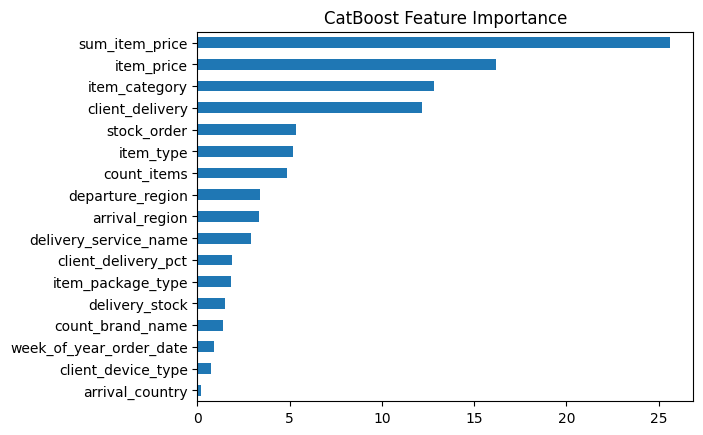

In [ ]:
feature_importance_series = pd.Series(index=catboost_model_basic_regr.feature_names_,
                                      data=catboost_model_basic_regr.feature_importances_)

# Фильтрация признаков с importance > 0
selected_features = feature_importance_series[feature_importance_series > 0.01]

# Сортировка и построение графика
selected_features.sort_values().plot(kind='barh')
_ = plt.title("CatBoost Feature Importance")

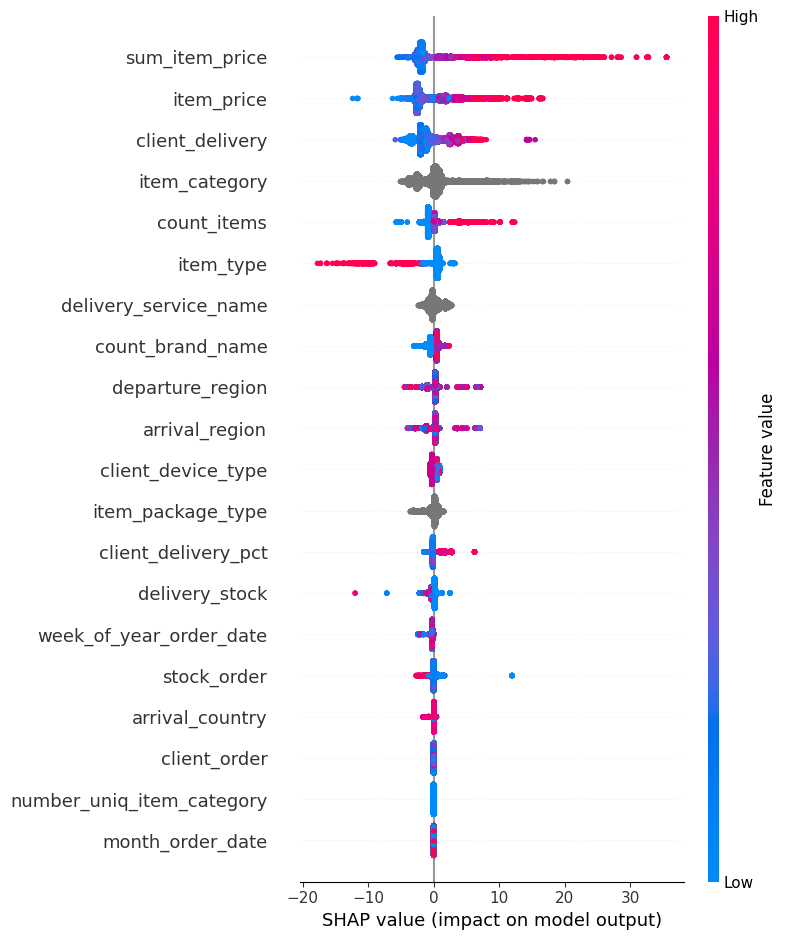

In [ ]:
import shap

explainer = shap.TreeExplainer(catboost_model_basic_regr)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,
                  feature_names = catboost_model_basic_regr.feature_names_)

>расходы за отказ от покупки зависят от
- суммы покупки
- категории покупки
- времени доставки
- типа доставки
- региона отправления
- региона доставки

### анализ ошибок

In [ ]:
calc_metrics_spec(y_train['item_losses'], catboost_model_basic_regr.predict(X_train))

{'msle_positive': 1.3421153154976377,
 'mse_positive': 5982.777018484767,
 'mae_positive': 59.59885179116775,
 'msle_zero': 9.72720173833838,
 'mse_zero': 612.1111160278112,
 'mae_zero': 22.80221901675608}

In [ ]:
metrics_base_regr = calc_metrics_spec(y_test['item_losses'],
                                      catboost_model_basic_regr.predict(X_test))

metrics_base_regr

{'msle_positive': 1.3383344690631667,
 'mse_positive': 5420.228453837738,
 'mae_positive': 56.07309867820168,
 'msle_zero': 9.698965399224747,
 'mse_zero': 607.5680226524713,
 'mae_zero': 22.66787117285578}

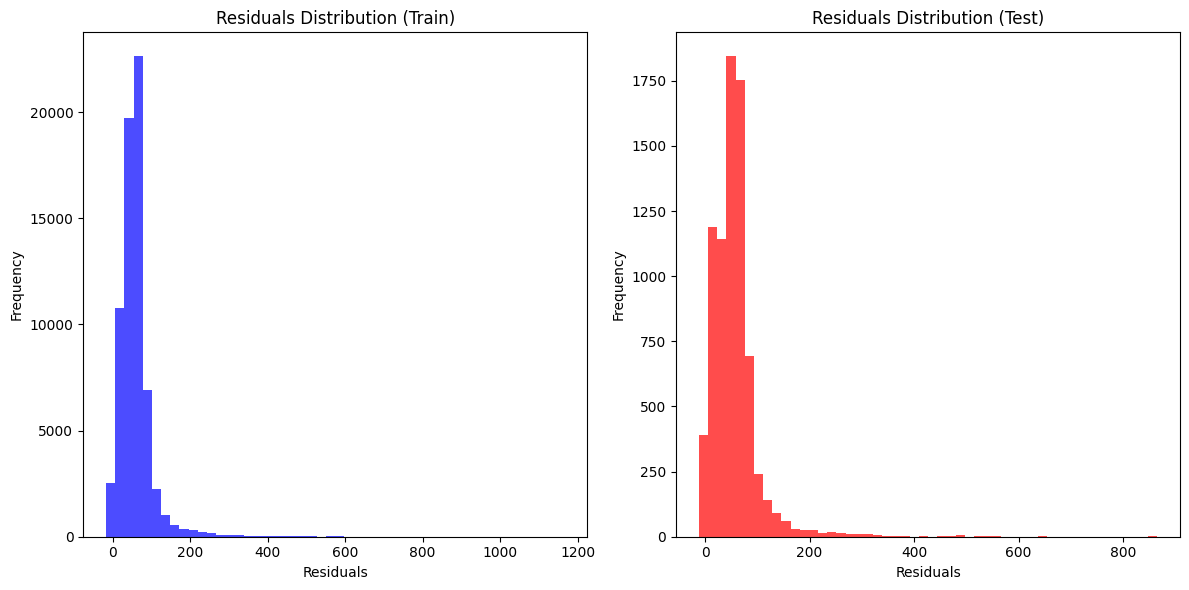

In [ ]:
get_errors_hist(y_train['item_losses'],
           catboost_model_basic_regr.predict(X_train),
           y_test['item_losses'],
           catboost_model_basic_regr.predict(X_test))

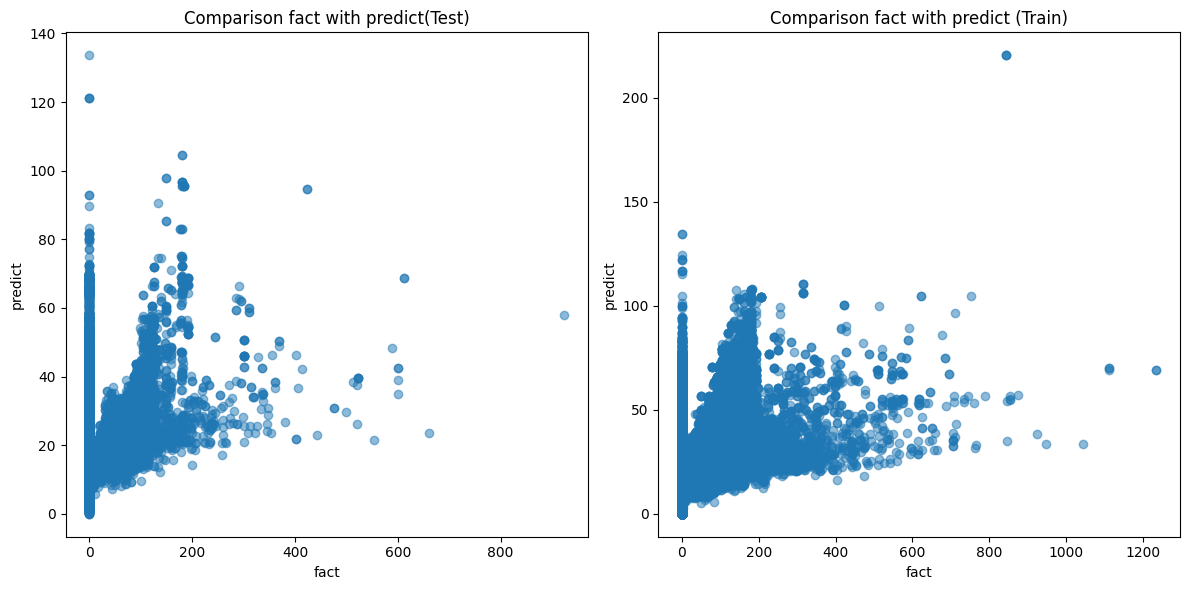

In [ ]:
compare_fact_forecast(y_train['item_losses'],
                      catboost_model_basic_regr.predict(X_train),
                      y_test['item_losses'],
                      catboost_model_basic_regr.predict(X_test))

> модель сильно занижает прогнозы, видно максимальные расходы, которые может спрогнозировать модель - не более 140.  
Это связано с 2 причинами:
 - больше 70% в данных - нулевые расходы
 - высокие расходы - редкое событие

## 2-ая версия - двуступенчатая модель

### построение бинарной классификации

In [ ]:
train_dataset = Pool(X_train, y_train['item_losses_bin'], cat_features=features_cat)
test_dataset = Pool(X_test, y_test['item_losses_bin'], cat_features=features_cat)

In [ ]:
%%time
catboost_model_bin = CatBoostClassifier(n_estimators=100,
                                        loss_function='Logloss',
                                        eval_metric='AUC:hints=skip_train~false',
                                        logging_level='Silent',
                                        )
_ = catboost_model_bin.fit(train_dataset,
                                  eval_set = test_dataset,
                                  use_best_model = True,
                                  plot = False,
                                  verbose=False
                                  )

CPU times: user 53.5 s, sys: 561 ms, total: 54.1 s
Wall time: 34.5 s


In [ ]:
catboost_model_bin.get_params()

{'loss_function': 'Logloss',
 'logging_level': 'Silent',
 'eval_metric': 'AUC:hints=skip_train~false',
 'n_estimators': 100}

In [ ]:
catboost_model_bin.best_score_


{'learn': {'Logloss': 0.46151862369549346, 'AUC': 0.7860955844745661},
 'validation': {'Logloss': 0.48140039812511015, 'AUC': 0.7623523459426862}}

In [ ]:
preds_test = catboost_model_bin.predict_proba(test_dataset)[:,1]
roc_auc_score(y_test['item_losses_bin'], preds_test)

0.7623523459426862

In [ ]:
preds_train = catboost_model_bin.predict_proba(train_dataset)[:,1]
roc_auc_score(y_train['item_losses_bin'], preds_train)

0.7895878338401935

In [ ]:
y_test['pred'] = catboost_model_bin.predict_proba(test_dataset)[:,1]

In [ ]:
y_test.sort_values('item_losses_bin')

,item_losses_bin,item_losses_pct,item_losses,pred
190387,0,0.000000,0.000000,0.181260
214059,0,0.000000,0.000000,0.168536
54974,0,0.000000,0.000000,0.426124
54973,0,0.000000,0.000000,0.426124
54975,0,0.000000,0.000000,0.426124
...,...,...,...,...
179102,1,0.548225,31.322524,0.898184
69409,1,0.109267,99.290459,0.215797
17226,1,0.114222,97.478865,0.283346
168138,1,0.254388,126.470936,0.196169


In [ ]:
y_test.groupby('item_losses_bin').mean()

,item_losses_pct,item_losses,pred
item_losses_bin,,,
0,0.000000,0.000000,0.228484
1,0.252262,80.490102,0.455429


In [ ]:
from sklearn.metrics import roc_curve
def calc_optimal_cutoff(y_true, predictions):
    fpr, tpr, thresholds = roc_curve(y_true, predictions)

    # Находим разность между TPR и FPR
    tpr_minus_fpr = tpr - fpr

    # Находим индекс максимальной разности между TPR и FPR
    best_index = np.argmax(tpr_minus_fpr)

    # Получаем оптимальный порог
    optimal_cutoff = thresholds[best_index]

    return optimal_cutoff

In [ ]:
cutoff = calc_optimal_cutoff(y_train['item_losses_bin'], preds_train)
cutoff

0.27563764584958966

### построим регрессию для наблюдений, когда item_losses>0

In [ ]:
y_train_pos_losses = y_train[y_train['item_losses_bin'] == 1]
X_train_pos_losses = X_train[X_train.index.isin(y_train[y_train['item_losses_bin'] == 1].index)]

y_test_pos_losses = y_test[y_test['item_losses_bin'] == 1]
X_test_pos_losses = X_test[X_test.index.isin(y_test[y_test['item_losses_bin'] == 1].index)]


In [ ]:
train_dataset_pos_losses = Pool(X_train_pos_losses,
                                y_train_pos_losses['item_losses'],
                                cat_features=features_cat)
test_dataset_pos_losses = Pool(X_test_pos_losses,
                               y_test_pos_losses['item_losses'],
                               cat_features=features_cat)

In [ ]:
# построим теперь регрессию только для тех наблюдений, где таргет не 0
%%time

catboost_model_regr = CatBoostRegressor(n_estimators=200,
                                        loss_function='RMSE',
                                        eval_metric='MSLE',
                                        logging_level='Silent')
_ = catboost_model_regr.fit(train_dataset_pos_losses,
                                  eval_set = test_dataset_pos_losses,
                                  use_best_model = True,
                                  plot = False,
                                  verbose=False
                                  )

CPU times: user 1min 1s, sys: 638 ms, total: 1min 2s
Wall time: 37 s


### анализ ошибок

1) P(не 0)* прогноз регрессии + P(0)*0
2) p(не 0)> cutoff then прогноз регрессии иначе 0

In [ ]:
# pred_test = catboost_model_regr.predict(X_test)*catboost_model_bin.predict_proba(test_dataset)[:,1]


pred_test = np.where(catboost_model_bin.predict_proba(test_dataset)[:,1] < cutoff,
                     0, catboost_model_regr.predict(X_test))

len(pred_test)

28207

In [ ]:
# pred_train = catboost_model_regr.predict(X_train)*catboost_model_bin.predict_proba(train_dataset)[:,1]

pred_train = np.where(catboost_model_bin.predict_proba(train_dataset)[:,1] < cutoff,
                     0, catboost_model_regr.predict(X_train))

In [ ]:
metrics_test_2_step = calc_metrics_spec(y_test['item_losses'].values,
                                        pred_test)
metrics_test_2_step

{'msle_positive': 8.247301554425132,
 'mse_positive': 5756.455372305159,
 'mae_positive': 46.50698862019148,
 'msle_zero': 4.512992729864073,
 'mse_zero': 2072.0274046703744,
 'mae_zero': 20.080141813232537}

In [ ]:
calc_metrics_spec(y_train['item_losses'], pred_train)

{'msle_positive': 7.529484617923925,
 'mse_positive': 5559.630870979856,
 'mae_positive': 43.534818770564975,
 'msle_zero': 4.524085582689061,
 'mse_zero': 2250.8382213652517,
 'mae_zero': 20.932141002789372}

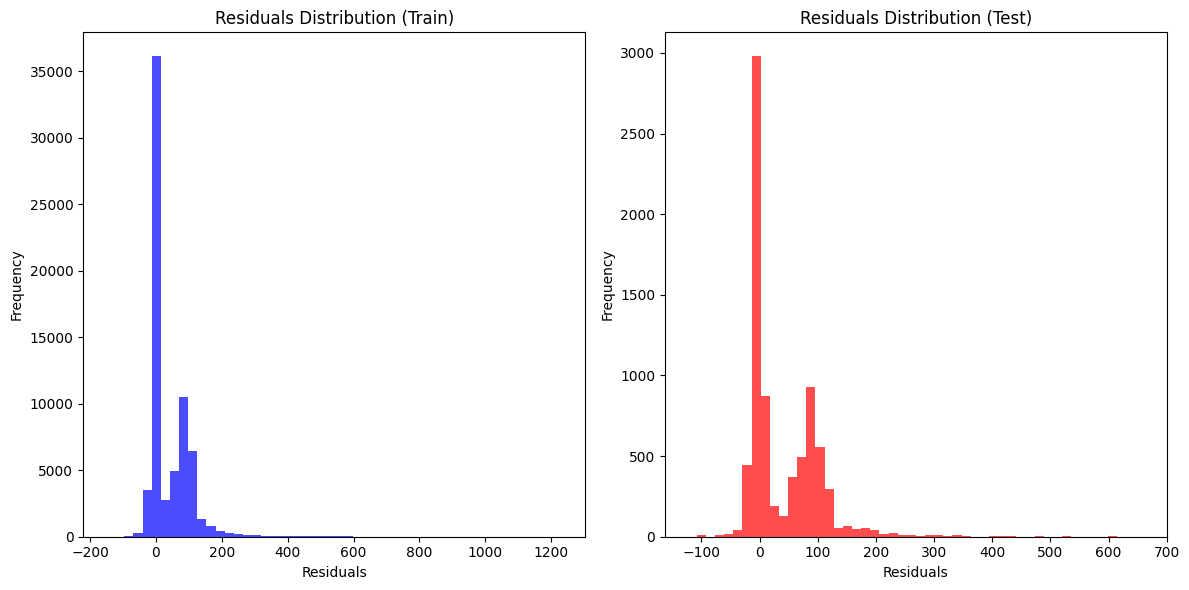

In [ ]:
get_errors_hist(y_train['item_losses'],
                pred_train,
                y_test['item_losses'],
                pred_test)

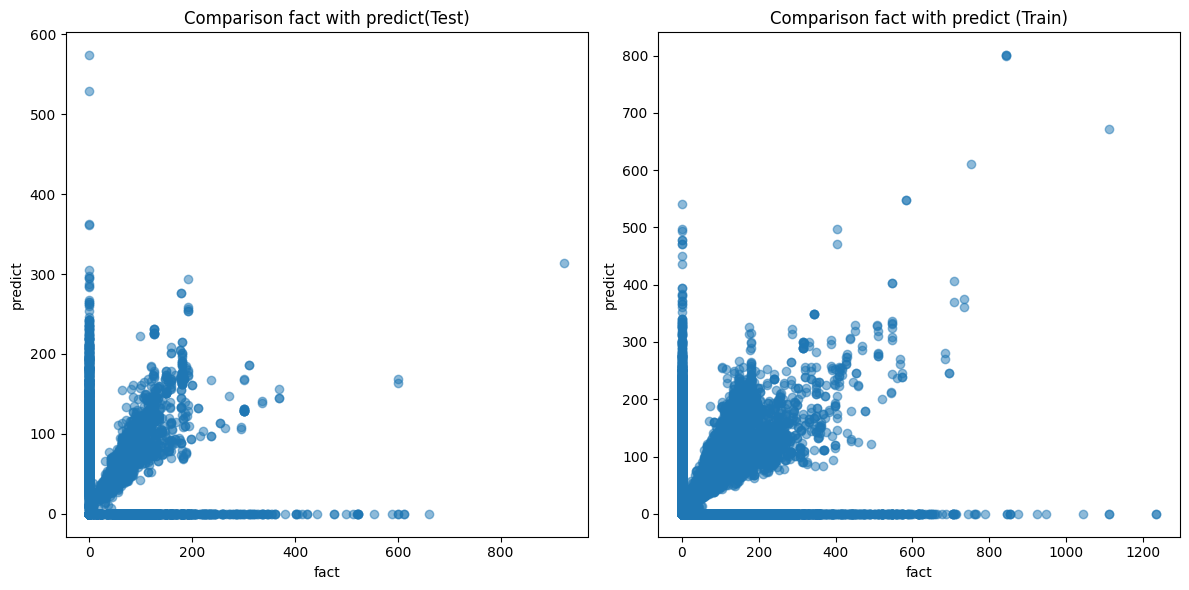

In [ ]:
compare_fact_forecast(y_train['item_losses'],
                      pred_train,
                      y_test['item_losses'],
                      pred_test)

<Axes: >

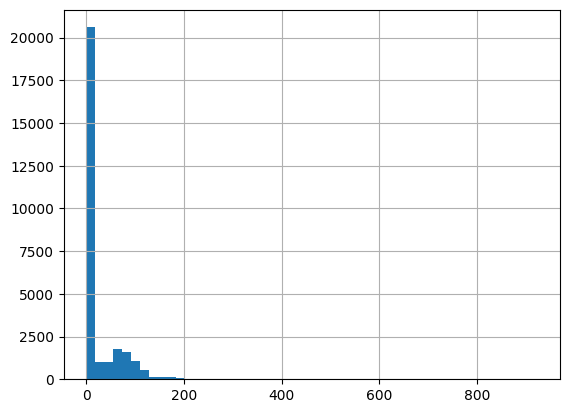

In [ ]:
y_test['item_losses'].hist(bins=50)

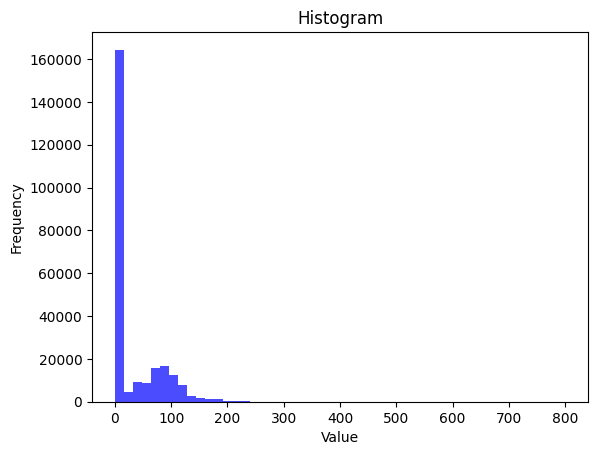

In [ ]:
plt.hist(pred_train, bins=50, color='blue', alpha=0.7)
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Показываем график
plt.show()

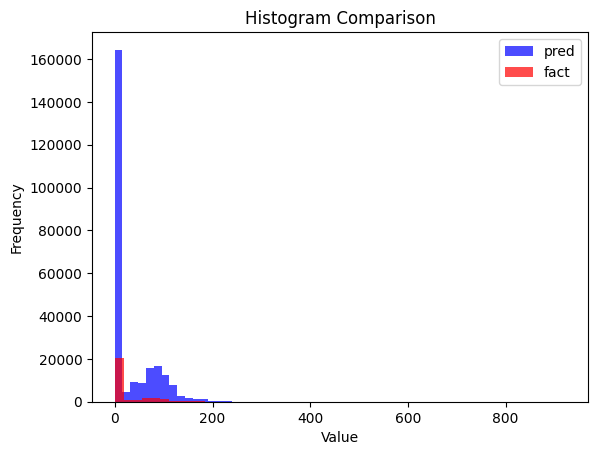

In [ ]:

plt.hist(pred_train, bins=50, color='blue', alpha=0.7, label='pred')

plt.hist(y_test['item_losses'], bins=50, color='red', alpha=0.7, label='fact')


plt.title('Histogram Comparison')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.legend()

plt.show()

In [ ]:
metrics_test_2_step, metrics_base_regr

({'msle_positive': 8.247301554425132,
  'mse_positive': 5756.455372305159,
  'mae_positive': 46.50698862019148,
  'msle_zero': 4.512992729864073,
  'mse_zero': 2072.0274046703744,
  'mae_zero': 20.080141813232537},
 {'msle_positive': 1.3383344690631667,
  'mse_positive': 5420.228453837738,
  'mae_positive': 56.07309867820168,
  'msle_zero': 9.698965399224747,
  'mse_zero': 607.5680226524713,
  'mae_zero': 22.66787117285578})

> ВЫВОД:
Данные не распределены нормально, есть толстый хвост, поэтому будем ориентироваться на метрики MAE


>двуступенчатый подход показал себя чуть лучше чем просто регрессия.  mae_positive для регрессии равно 56 и mae_zero=22, для двуступенчатой модели mse_positive = 46, mae_zero=22



# Применяем модель к тесту

In [ ]:
df_test.head()

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,count_brand_name,count_items,sum_item_price,number_uniq_item_category,item_price_more_0,sum_item_with_price_0,count_in_hist_item_category_0,count_in_hist_item_category_1,count_in_hist_item_category_2,count_in_hist_item_category_3,count_in_hist_item_category_4,count_in_hist_item_category_5,day_of_week_order_date,week_of_year_order_date,month_order_date,client_order,stock_order,stock_order_pct,delivery_stock,delivery_stock_pct,client_delivery,client_delivery_pct
60109,6add247b-3c23-49fd-8d1e-0442541c7bd6,12,125,824,12,121,1732,2018-03-01 00:37:48,2018-03-03 19:45:00,2018-03-03 19:45:00,2018-03-03 23:48:00,0,None,0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],cf25b5d0-8c3d-440f-8377-fea2e3459a9e,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,979.008977,1,2,1748.208208,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,9,3,4270.200000,4027.200000,0.943094,0.0,0.0,243.0,0.056906
60108,6add247b-3c23-49fd-8d1e-0442541c7bd6,12,125,824,12,121,1732,2018-03-01 00:37:48,2018-03-03 19:45:00,2018-03-03 19:45:00,2018-03-03 23:48:00,0,None,0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],cf25b5d0-8c3d-440f-8377-fea2e3459a9e,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,769.199231,1,2,1748.208208,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,3,9,3,4270.200000,4027.200000,0.943094,0.0,0.0,243.0,0.056906
64915,d2d10ea9-b53f-4a78-b6ea-240a63aa0d74,12,121,1732,12,125,824,2018-03-01 00:42:53,2018-03-04 16:15:00,2018-03-04 16:15:00,2018-03-04 20:02:00,0,None,2,1,7b0818f4-617e-4843-a5c1-634d2c2a3c2f,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],ef4136ef-12d7-45fe-8cf8-53fced8c9cf3,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,2326.670752,1,2,4656.280735,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,9,3,5479.116667,5252.116667,0.958570,0.0,0.0,227.0,0.041430
64914,d2d10ea9-b53f-4a78-b6ea-240a63aa0d74,12,121,1732,12,125,824,2018-03-01 00:42:53,2018-03-04 16:15:00,2018-03-04 16:15:00,2018-03-04 20:02:00,0,None,2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],ef4136ef-12d7-45fe-8cf8-53fced8c9cf3,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,2329.609983,1,2,4656.280735,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,3,9,3,5479.116667,5252.116667,0.958570,0.0,0.0,227.0,0.041430
63342,94fd0ee8-052a-474f-ab23-82f66bb7b533,12,162,888,12,121,1405,2018-03-01 00:43:33,2018-03-01 19:33:00,2018-03-01 19:33:00,2018-03-01 23:10:00,0,"[2, 3, 11]",0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['e8ace2ea-968a-408c-a992-bb5924c01239'],cc28fd69-f09c-4d9a-8cd5-a5c9b75a41b3,60959c0c-9c1a-434b-8442-3b8c2fc73655,5c8a6701-853f-4721-86f0-86e79f7220c4,0,736.616971,1,1,736.616971,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,9,3,1346.450000,1129.450000,0.838835,0.0,0.0,217.0,0.161165


In [ ]:
df_test_features = df_test[features_int + features_bin + features_cat].copy()


df_test['item_losses'] = np.where(catboost_model_bin.predict_proba(df_test_features)[:,1] < cutoff,
                     0, catboost_model_regr.predict(df_test_features))

# df_test_features['item_losses'] = catboost_model_regr.predict(df_test_features)*catboost_model_bin.predict_proba(df_test_features)[:,1]



In [ ]:
df_test.head()

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,count_brand_name,count_items,sum_item_price,number_uniq_item_category,item_price_more_0,sum_item_with_price_0,count_in_hist_item_category_0,count_in_hist_item_category_1,count_in_hist_item_category_2,count_in_hist_item_category_3,count_in_hist_item_category_4,count_in_hist_item_category_5,day_of_week_order_date,week_of_year_order_date,month_order_date,client_order,stock_order,stock_order_pct,delivery_stock,delivery_stock_pct,client_delivery,client_delivery_pct,item_losses
60109,6add247b-3c23-49fd-8d1e-0442541c7bd6,12,125,824,12,121,1732,2018-03-01 00:37:48,2018-03-03 19:45:00,2018-03-03 19:45:00,2018-03-03 23:48:00,0,None,0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],cf25b5d0-8c3d-440f-8377-fea2e3459a9e,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,979.008977,1,2,1748.208208,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,9,3,4270.200000,4027.200000,0.943094,0.0,0.0,243.0,0.056906,0.000000
60108,6add247b-3c23-49fd-8d1e-0442541c7bd6,12,125,824,12,121,1732,2018-03-01 00:37:48,2018-03-03 19:45:00,2018-03-03 19:45:00,2018-03-03 23:48:00,0,None,0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],cf25b5d0-8c3d-440f-8377-fea2e3459a9e,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,769.199231,1,2,1748.208208,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,3,9,3,4270.200000,4027.200000,0.943094,0.0,0.0,243.0,0.056906,0.000000
64915,d2d10ea9-b53f-4a78-b6ea-240a63aa0d74,12,121,1732,12,125,824,2018-03-01 00:42:53,2018-03-04 16:15:00,2018-03-04 16:15:00,2018-03-04 20:02:00,0,None,2,1,7b0818f4-617e-4843-a5c1-634d2c2a3c2f,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],ef4136ef-12d7-45fe-8cf8-53fced8c9cf3,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,2326.670752,1,2,4656.280735,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,9,3,5479.116667,5252.116667,0.958570,0.0,0.0,227.0,0.041430,0.000000
64914,d2d10ea9-b53f-4a78-b6ea-240a63aa0d74,12,121,1732,12,125,824,2018-03-01 00:42:53,2018-03-04 16:15:00,2018-03-04 16:15:00,2018-03-04 20:02:00,0,None,2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],ef4136ef-12d7-45fe-8cf8-53fced8c9cf3,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,2329.609983,1,2,4656.280735,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,3,9,3,5479.116667,5252.116667,0.958570,0.0,0.0,227.0,0.041430,358.747565
63342,94fd0ee8-052a-474f-ab23-82f66bb7b533,12,162,888,12,121,1405,2018-03-01 00:43:33,2018-03-01 19:33:00,2018-03-01 19:33:00,2018-03-01 23:10:00,0,"[2, 3, 11]",0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['e8ace2ea-968a-408c-a992-bb5924c01239'],cc28fd69-f09c-4d9a-8cd5-a5c9b75a41b3,60959c0c-9c1a-434b-8442-3b8c2fc73655,5c8a6701-853f-4721-86f0-86e79f7220c4,0,736.616971,1,1,736.616971,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,9,3,1346.450000,1129.450000,0.838835,0.0,0.0,217.0,0.161165,0.000000


In [ ]:
df_test_features.shape[0] == df_test.shape[0]

True

In [ ]:
df_test.to_csv('df_test.csv')

<Axes: >

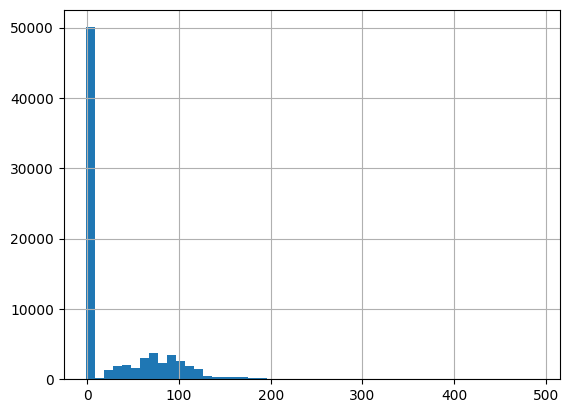

In [ ]:
df_test['item_losses'].hist(bins=50)

# Улучшение и дальнейшие шаги

- создание дополнительных признаков на основании истории покупок
- создание дополнительных переменных на основании города, региона доставки
- создание дополнительных переменных на основании маршрута

- построить модели с относительным таргетом item_losses_pct

- другие модели машинного обучения (LightGBM, возможно подойдут нейронки  (хотя обычно нейронки на практике у меня проигрывают на табличных данных )

- провести более детальный анализ остатков, возможно стоит объединить модель и правила статистические, которые будут улучшать проблемы проогноза моделей машинного обучения

- подобрать параметры с помощью grisearch, например вот так

```
grid = {'iterations': [100, 150, 200],
         'learning_rate': [0.03, 0.1],
         'depth': [2, 4, 6, 8],
         'l2_leaf_reg': [0.2, 0.5, 1, 3]}

 _ = catboost_model_basic_regr.grid_search(grid, train_dataset, cv=5, plot=False, verbose=False)

```
